In [1]:
!pip install tensorflow_addons

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
!pip install textblob

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from textblob import TextBlob
from nltk.stem import PorterStemmer,SnowballStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from io import StringIO
import string
import gensim
from gensim.models import Word2Vec
import itertools
import scipy
from scipy import spatial
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
tokenizer = ToktokTokenizer()
# stopword_list = nltk.corpus.stopwords.words('english')   
# stopword_list = nltk.download('stopwords')

In [38]:
# !pip install textblob nltk gensim wordcloud

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
import os
from minio import Minio


In [41]:
# HOST = "http://mlflow:5500"

PROJECT_NAME = "NLPTextClassification"
EXPERIMENT_NAME = "DeepLearning"

os.environ['MLFLOW_S3_ENDPOINT_URL']='http://minio-ml-workshop:9000'
os.environ['AWS_ACCESS_KEY_ID']='minio'
os.environ['AWS_SECRET_ACCESS_KEY']='minio123'
os.environ['AWS_REGION']='us-east-1'
os.environ['AWS_BUCKET_NAME']='raw-data-saeed'

In [42]:
def get_s3_server():
    minioClient = Minio('minio-ml-workshop:9000',
                    access_key='minio',
                    secret_key='minio123',
                    secure=False)

    return minioClient

In [43]:
client = get_s3_server()

In [44]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [45]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
# df = pd.read_csv("consumer_complaints.csv")
csv_file = client.get_object("raw-data-saeed", "consumer_complaints.csv")
df = pd.read_csv(csv_file)

# df = df[:50000]

In [47]:
df.head()


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [48]:
df.dtypes


date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object

In [49]:
df.describe(include='all')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
count,555957,555957,397635,555957,212622,66806,85124,555957,551070,551452,77959,123458,555957,555957,555957,555957,555957,5.559570e+05
unique,1608,11,46,95,68,65646,10,3605,62,27052,3,4,6,1557,8,2,2,NaN
top,08/27/2015,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",Account status,This company continues to report on my credit ...,Company chooses not to provide a public response,Bank of America,CA,300XX,Older American,Consent provided,Web,11/13/2015,Closed with explanation,Yes,No,NaN
freq,963,186475,74319,97191,26798,37,52478,55998,81700,1205,45257,66807,361338,1108,404293,541909,443823,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.600510e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.504296e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.863230e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.737830e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.441702e+06


In [50]:
df.isnull().sum()/df.shape[0]*100


date_received                    0.000000
product                          0.000000
sub_product                     28.477382
issue                            0.000000
sub_issue                       61.755675
consumer_complaint_narrative    87.983603
company_public_response         84.688744
company                          0.000000
state                            0.879025
zipcode                          0.810314
tags                            85.977513
consumer_consent_provided       77.793606
submitted_via                    0.000000
date_sent_to_company             0.000000
company_response_to_consumer     0.000000
timely_response                  0.000000
consumer_disputed?               0.000000
complaint_id                     0.000000
dtype: float64

In [68]:
df1 = df[['complaint_id','date_received','product','issue','company','state','submitted_via','company_response_to_consumer','timely_response','consumer_disputed?','consumer_complaint_narrative']]


In [69]:
df1 = df1[pd.notnull(df1['consumer_complaint_narrative'])]
# df1 =  df1[:10000]
df1.sample(n = 40000)
df1.reset_index(drop=True,inplace = True)


## EDA
We’ll check the disribution of complaints by product category to understand which product received maximum complaints and 

other products which rarely receive complaints.



<AxesSubplot:xlabel='product', ylabel='count'>

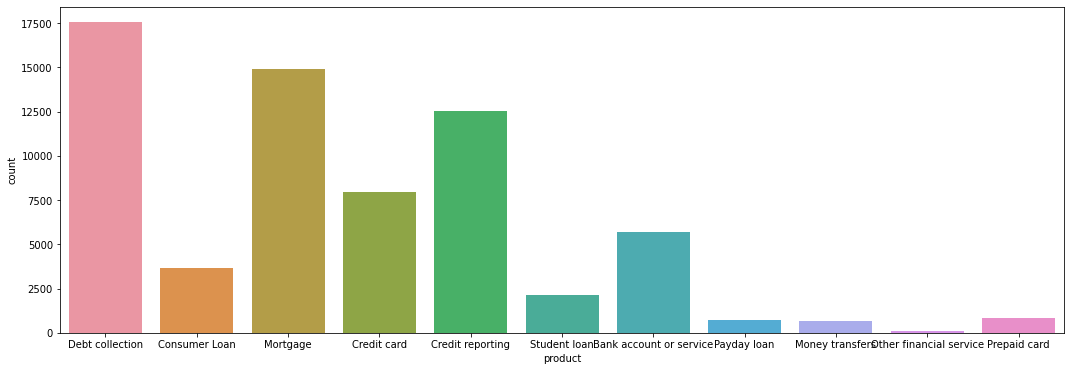

In [70]:
fig,ax = plt.subplots(figsize=(18,6))
sns.countplot(x='product',data=df1)

From this plot we can see Debt Collection and Mortgage received maximum number of complaints

We’ll now analyze the contingency table in form of plot to understand which product has more customer disputes on their complaints after resolving the issues

<AxesSubplot:xlabel='product'>

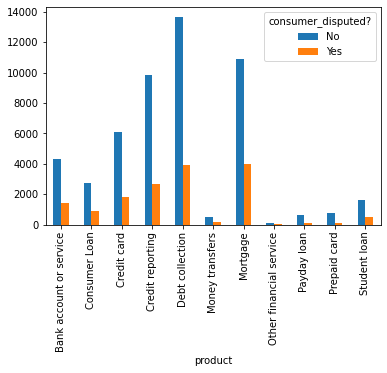

In [71]:
pd.crosstab(df1['product'],df1['consumer_disputed?']).plot(kind='bar')


Not much of difference in proportion of disputes raised by complaint for each product category.

Checking various plots to identify patterns within data

In [72]:
df1['date_received'] = pd.to_datetime(df1['date_received'])
df1.date_received.min(),df1.date_received.max()


(Timestamp('2015-03-19 00:00:00'), Timestamp('2016-04-20 00:00:00'))

<AxesSubplot:xlabel='month', ylabel='count'>

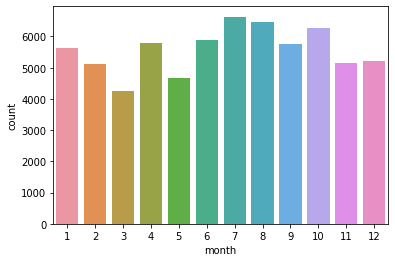

In [73]:
df1['month'] = df1['date_received'].dt.month
sns.countplot(x='month',data=df1)

<AxesSubplot:xlabel='timely_response', ylabel='count'>

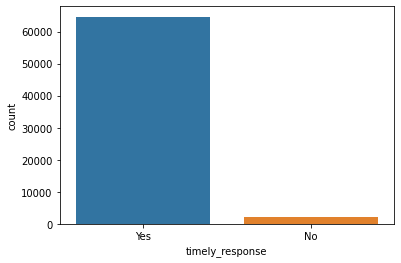

In [74]:
sns.countplot(x='timely_response',data=df1)


# Text Data Preprocessing


## Converting Text data to Lowercase


In [75]:
df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))
df1['consumer_complaint_narrative'].sample(2)



7673     my name is : xxxx xxxxloan # xxxxaddress of co...
54527    i opened a xxxx account with a promotion code ...
Name: consumer_complaint_narrative, dtype: object

## Removing Punctuations


In [76]:
df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].str.replace(r'[^\w\s]',"")
df1['consumer_complaint_narrative'].sample(2)


16148    on xxxxxxxx i received a letter from wells far...
10883    us bank offered me a payment arrangement via x...
Name: consumer_complaint_narrative, dtype: object

## Text standardization


In [77]:
# #Below, we used three normalizazion dictionaries from these links :
# #http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/
# #http://people.eng.unimelb.edu.au/tbaldwin/etc/emnlp2012-lexnorm.tgz
# #http://luululu.com/tweet/typo-corpus-r1.txt
dico = {}
dico1 = open('doc1.txt', 'rb')
for word in dico1:
    word = word.decode('utf8')
    word = word.split()
    dico[word[1]] = word[3]
dico1.close()
dico2 = open('doc2.txt', 'rb')
for word in dico2:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico2.close()
dico3 = open('doc3.txt', 'rb')
for word in dico3:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico3.close()

In [78]:
def txt_std(words):
    list_words = words.split()
    for i in range(len(list_words)):
        if list_words[i] in dico.keys():
            list_words[i] = dico[list_words[i]]
    return ' '.join(list_words)

In [79]:
df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].apply(txt_std)
df1.consumer_complaint_narrative.head(1)


0    xxxx has claimed i owe them 2700 for xxxx year...
Name: consumer_complaint_narrative, dtype: object

In [80]:

df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].str.replace(r"xx+\s","")
df1['consumer_complaint_narrative'].head(1)


0    has claimed i owe them 2700 for years despite ...
Name: consumer_complaint_narrative, dtype: object

## Removing Stopwords


In [81]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))
df1['consumer_complaint_narrative'].head(1)


0    claimed owe 2700 years despite proof payment s...
Name: consumer_complaint_narrative, dtype: object

## Correcting Spelling


In [82]:
# from pyspark.sql import SparkSession
# import spark_util
# from pyspark.sql.types import *

# # Auxiliar functions
# def equivalent_type(f):
#     if f == 'datetime64[ns]': return TimestampType()
#     elif f == 'int64': return LongType()
#     elif f == 'int32': return IntegerType()
#     elif f == 'float64': return FloatType()
#     else: return StringType()

# def define_structure(string, format_type):
#     try: typo = equivalent_type(format_type)
#     except: typo = StringType()
#     return StructField(string, typo)

# # Given pandas dataframe, it will return a spark's dataframe.
# def pandas_to_spark(pandas_df):
#     columns = list(pandas_df.columns)
#     types = list(pandas_df.dtypes)
#     struct_list = []
#     for column, typo in zip(columns, types): 
#       struct_list.append(define_structure(column, typo))
#     p_schema = StructType(struct_list)
#     return spark.createDataFrame(pandas_df, p_schema)

# spark = spark_util.getOrCreateSparkSession("Hello from Notebook")
# sc = spark.sparkContext

# # nums = sc.parallelize([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

# # nums = spark.createDataFrame(df1, df1.info)
# nums = pandas_to_spark(df1)
# nums.printSchema()

# def texblobb(x):
# #     import subprocess
# #     import sys
# #     subprocess.check_call([sys.executable, "-m", "pip3", "install", "textblob","--user"])
# #     from textblob import TextBlob
    
#     return str(TextBlob(x['consumer_complaint_narrative']).correct())

# nums.rdd.map(texblobb ).collect() 


# # from pyspark.sql.functions import col
# # col("consumer_complaint_narrative")


In [83]:
# spark.stop()

In [84]:
##ensure text is standardized before applying this step
from textblob import TextBlob


for index, row in df1.iterrows():
#     row['consumer_complaint_narrative'] =TextBlob(row['consumer_complaint_narrative']).correct() 
#     for i, row in df.iterrows():
#     if <something>:
    df1.at[index, 'consumer_complaint_narrative'] = TextBlob(df1.at[index, 'consumer_complaint_narrative']).correct() 
    if index%1000 ==0:
        print(index)
    
# df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].apply(lambda x: str(TextBlob(x).correct()))
# df1.consumer_complaint_narrative.head(1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
20000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


KeyboardInterrupt: 

##### df1.iloc[:10]['consumer_complaint_narrative'] =df1.iloc[:10]['consumer_complaint_narrative'].apply(lambda x: str(TextBlob(x).correct()))


## Lemmatizing


In [ ]:
# from textblob import Word



# for index, row in df1.iterrows():
# #     row['consumer_complaint_narrative'] =TextBlob(row['consumer_complaint_narrative']).correct() 
# #     for i, row in df.iterrows():
# #     if <something>:
#     df1.at[index, 'consumer_complaint_narrative'] = ' '.join([Word(i).lemmatize() for i in df1.at[index, 'consumer_complaint_narrative'].split()])
#     if index%1000 ==0:
#         print(index)

In [85]:
from textblob import Word



df1['consumer_complaint_narrative'] =df1['consumer_complaint_narrative'].apply(lambda x:' '.join([Word(i).lemmatize() for i in x.split()]))
df1.consumer_complaint_narrative.head(1)


0    claimed owe 2700 year despite proof payment se...
Name: consumer_complaint_narrative, dtype: object

In [87]:
# df1.to_csv(r'large_cc_data.csv')
# Upload data.
result = client.fput_object(
   "raw-data-saeed", "large_cc_data.csv", "large_cc_data.csv",content_type="application/csv",
)

In [ ]:
csv_file = client.get_object("raw-data-saeed", "data.csv")
df1 = pd.read_csv(csv_file)

# Word Cloud for all Product categories


In [ ]:
!pip install wordcloud


In [ ]:
from wordcloud import WordCloud

In [ ]:
for product_name in df1['product'].unique():
    print(product_name)
    all_words = ' '.join([text for text in df1.loc[df1['product'].str.contains(product_name),'consumer_complaint_narrative']])
    
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


In [ ]:
df1.shape

### Train/Test split


In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(df1['consumer_complaint_narrative'], df1['product'],stratify=df1['product'], 
                                                    test_size=0.30)



Feature engineering of consumer complaint with TF-IDF

In [ ]:

##label encoding target variable
enc = preprocessing.LabelEncoder()
train_y = enc.fit_transform(train_y)
valid_y = enc.fit_transform(valid_y)


In [ ]:

##tf-idf verctor representation
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df1['consumer_complaint_narrative'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)


## Deep Learning models


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Sequential


In [ ]:

total_complaints = np.append(train_x.values,valid_x.values)
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(train_x.values)#total_complaints
train_sequences = tokenizer.texts_to_sequences(train_x.values)
test_sequences = tokenizer.texts_to_sequences(valid_x.values)


In [ ]:

word_index = tokenizer.word_index# dictionary containing words and their index
print('Found %s unique tokens.' % len(word_index))


In [ ]:

MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])
MAX_SEQUENCE_LENGTH


In [ ]:

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
print(train_data.shape)
print(test_data.shape)


In [ ]:

enc = preprocessing.LabelEncoder()
train_labels = enc.fit_transform(train_y)
test_labels = enc.fit_transform(valid_y)

print(enc.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))


In [ ]:

labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_test.shape)



## CNN w/ Pre-trained word embeddings(GloVe)
We’ll use pre-trained embeddings such as Glove which provides word based vector representation trained on a large corpus.

It is trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words. The glove has embedding vector sizes, including 50, 100, 200 and 300 dimensions.



In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
f = client.get_object("raw-data-saeed", "glove.6B.50d.txt")
embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
# f = open( 'glove.6B.50d.txt')
for line in f:
    # print(line.decode("utf-8") )
    line = line.decode("utf-8")
    # break
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# # !wget http://nlp.stanford.edu/data/glove.6B.zip
# # f = client.get_object("raw-data-saeed", "glove.6B.50d.txt")
# embeddings_index = {}
# # f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
# f = open( 'glove.6B.50d.txt')
# for line in f:
#     # print(line)
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))



Now lets create the embedding matrix using the word indexer created from tokenizer.


In [ ]:

EMBEDDING_DIM = 50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Lets check the word embedded vector representation for token ‘loan’ in our embedding matrix


In [ ]:


[(k,v) for k,v in word_index.items() if v==4]


In [ ]:
embedding_matrix[4]  ## word embedded vector representation for token 'loan'

In [ ]:
vocab_size = len(tokenizer.word_index)+1


Now we load this embedding matrix into an Embedding layer using Sequential API to form a Convolutional NeuralNet model.
Dropout is applied between the hidden layers to factor regularization and prevent overfitting of neural network.



In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(128, 3, activation="relu"))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(512, 9, activation="relu"))
model.add(MaxPooling1D(9))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(11, activation="softmax"))
# model.compile(loss='categorical_crossentropy',
#  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
#  # optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1),
#               # optimizer='rmsprop',#rmsprop
#  metrics=['acc'])

model.compile(optimizer=tfa.optimizers.Yogi(0.001),
              # optimizer=tfa.optimizers.RectifiedAdam(0.001),
    # loss=tfa.losses.TripletSemiHardLoss(),
              loss='categorical_crossentropy',
              metrics=['acc']
    # metrics=[tfa.metrics.MultiLabelConfusionMatrix(num_classes=11)]
             )


In [ ]:
# model.summary()

In [ ]:
# model.trainable = True
# for layer in model.layers[:-12]:
#     layer.trainable =  False
# model.summary()

In [ ]:
history = model.fit(train_data, labels_train,
 batch_size=128,
 epochs=80,
 validation_data=(test_data, labels_test))


In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

After 3 epochs the CNN tends to be overfitting the training data and therefore we need to implement early stopping to prevent such instances of overfitting and tune the number of epochs during training.



In [ ]:
#predictions on test data
predicted=model.predict(test_data)
predicted

In [ ]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print(classification_report(labels_test, predicted.round(),target_names=df1['product'].unique()))


Now, we’ll initialize our Embedding layer from scratch and learning its weights during training instead of using a pre-trained word embeddings and build a small 1D convnet to solve our classification problem.



In [ ]:
#The Embedding layer requires the specification of the vocabulary size (vocab_size), 
#the size of the real-valued vector space EMBEDDING_DIM = 100,
#and the maximum length of input documents max_length .
vocab_size = len(tokenizer.word_index)+1
EMBEDDING_DIM = 50
max_length = 394

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,
 EMBEDDING_DIM,
 input_length=MAX_SEQUENCE_LENGTH
 ))
model.add(Dropout(0.3))
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(11, activation="softmax"))
model.compile(loss='categorical_crossentropy',
 # optimizer="rmsprop",
              optimizer=tfa.optimizers.RectifiedAdam(0.001),
 metrics=['acc'])

In [ ]:
history = model.fit(train_data, labels_train,
 batch_size=256,
 epochs=80,
 validation_data=(test_data, labels_test))

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training acc', 'Validation acc'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :CNN',fontsize=16)
plt.show()

In [ ]:
#predictions on test data
predicted=model.predict(test_data)
predicted

In [ ]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print("############################")
print(sklearn.metrics.classification_report(labels_test, predicted.round()))

In [ ]:
## RNN

In [ ]:
#Bidirectional LSTM
EMBEDDING_DIM = 50
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(Bidirectional(LSTM(100, dropout = 0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(256, dropout = 0.3)))
model.add(Dense(11,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


In [ ]:
history = model.fit(train_data, labels_train,
 batch_size=64,
 epochs=80,
 validation_data=(test_data, labels_test))

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN - LSTM',fontsize=16)
plt.show()

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training acc', 'Validation acc'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :RNN - LSTM',fontsize=16)
plt.show()

In [ ]:
#predictions on test data
predicted=model.predict(test_data)
predicted

In [ ]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))
print("############################")

In [ ]:
print(classification_report(labels_test, predicted.round(),target_names=df1['product'].unique()))


After hours of training we get good results with LSTM(type of recurrent neural network) compared to CNN. From the learning curves it is clear the model needs to be tuned for overfitting by selecting hyperparameters such as no of epochs via early stopping and dropout for regularization.

We could further improve our final result by ensembling our xgboost and Neural network models by using Logistic Regression as our base model.



In [ ]:
df1.to_csv(r'light_cc_data.csv')

## Step1: 
### Loading the Required packages

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py


Build a BERT Layer

In [ ]:
import tensorflow_hub as hub
import tokenization
# module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
# bert_layer = hub.KerasLayer(module_url, trainable=True)
module_url = 'https://tfhub.dev/google/small_bert/bert_uncased_L-8_H-768_A-12/1'

bert_layer = hub.KerasLayer(module_url, trainable=True, signature='tokens',signature_outputs_as_dict = True)

# bert_layer = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1", trainable=True)


## Step2: 
### Understand the Problem Statement and import the Datasets

I am using Git hub bugs prediction dataset and it is available in MachineHack platform. Our aim is to predict the bugs,features and questions based on GitHub titles and the text body.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df1['consumer_complaint_narrative'], df1['product'],stratify=df1['product'], 
                                                    test_size=0.30)


##label encoding target variable
enc = preprocessing.LabelEncoder()
train_labels = enc.fit_transform(train_y)
test_labels = enc.fit_transform(test_y)

labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))
print('Shape of data tensor:', train_x.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_test.shape)

In [ ]:


# ##label encoding target variable
# enc = preprocessing.LabelEncoder()
# train_y = enc.fit_transform(train_y)
# test_y = enc.fit_transform(test_y)
# test_y

bert_layer## Step3: 
### Encoding the raw text
Tokenization is a process to take raw texts and split into tokens, which are numeric data to represent words.

Official BERT language models are pre-trained with WordPiece vocabulary and use, not just token embeddings, but also segment embeddings distinguish between sequences, which are in pairs, e.g. question answering examples. Position embeddings are needed in order to inject positional awareness into the BERT model as the attention mechanism does not consider positions in context evaluation.

The important limitation of BERT to be aware of is that the maximum length of the sequence for BERT is 512 tokens. For shorter sequence input than the maximum allowed input size, we would need to add pad tokens [PAD]. On the other hand, if the sequence is longer, we need to cut the sequence. This BERT limitation on the maximum length of the sequence is something that you need to be aware of for longer text segments.

Very important are also the so-called special tokens, e.g. [CLS] token and [SEP] tokens. The [CLS] token will be inserted at the beginning of the sequence, the [SEP] token is at the end. If we deal with sequence pairs we will add additional [SEP] token at the end of the last.



In [ ]:
bert_layer.resolved_object.

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

Step 4: Build the Model


In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(11, activation='softmax')(net)
    print (out.shape)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False), metrics=['accuracy'])
    
    return model


In [ ]:
max_len = MAX_SEQUENCE_LENGTH
train_input = bert_encode(train_x, tokenizer, max_len=max_len)
test_input = bert_encode(test_x, tokenizer, max_len=max_len)
# enc = preprocessing.LabelEncoder()
# train_labels = enc.fit_transform(train_y)
# test_labels = enc.fit_transform(test_y)
# train_labels = to_categorical(np.asarray(train_labels))
# test_labels = to_categorical(np.asarray(test_labels))

In [ ]:
# df1['consumer_complaint_narrative'], df1['product']

In [ ]:
# df1.product

In [ ]:
# max_len = MAX_SEQUENCE_LENGTH
# train_input = bert_encode(df1.consumer_complaint_narrative.values, tokenizer, max_len=max_len)
# # test_input = bert_encode(test.consumer_complaint_narrative.values, tokenizer, max_len=max_len)
# enc = preprocessing.LabelEncoder()
# train_labels = enc.fit_transform(df1.product.values)
# # train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=11)


In [ ]:
# train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=11)
# test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=11)


In [ ]:
train_labels[1]

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

In [ ]:
model.trainable = True
for layer in model.layers[:-6]:
    layer.trainable =  False
model.summary()

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_data=(test_input, test_labels),
    # validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=1,
    verbose=1)

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)


In [ ]:
preprocessor = hub.load("https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/1")
tokenize = hub.KerasLayer(preprocessor.tokenize)
bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs)

In [ ]:
tokenized_inputs = [tokenize(segment) for segment in text_inputs]
encoder_inputs = bert_pack_inputs(tokenized_inputs)
encoder_outputs = encoder(encoder_inputs)

In [ ]:
import os
from minio import Minio
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import  preprocessing
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
# HOST = "http://mlflow:5500"

PROJECT_NAME = "NLPTextClassification"
EXPERIMENT_NAME = "DeepLearning"

os.environ['MLFLOW_S3_ENDPOINT_URL']='http://minio-ml-workshop:9000'
os.environ['AWS_ACCESS_KEY_ID']='minio'
os.environ['AWS_SECRET_ACCESS_KEY']='minio123'
os.environ['AWS_REGION']='us-east-1'
os.environ['AWS_BUCKET_NAME']='raw-data-saeed'
def get_s3_server():
    minioClient = Minio('minio-ml-workshop:9000',
                    access_key='minio',
                    secret_key='minio123',
                    secure=False)

    return minioClient
client = get_s3_server()

In [ ]:
csv_file = client.get_object("raw-data-saeed", "light_cc_data.csv")
df1 = pd.read_csv(csv_file)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df1['consumer_complaint_narrative'], df1['product'],stratify=df1['product'], 
                                                    test_size=0.30)


##label encoding target variable
enc = preprocessing.LabelEncoder()
train_labels = enc.fit_transform(train_y)
test_labels = enc.fit_transform(test_y)

labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))
print('Shape of data tensor:', train_x.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_test.shape)

In [ ]:
MAX_SEQUENCE_LENGTH = 348
maxlen = 348

## Implement a Transformer block as a layer


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Implement embedding layer
Two seperate embedding layers, one for tokens, one for token index (positions).


In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Prepare dataset

In [ ]:

vocab_size = 25000  # Only consider the top 20k words
maxlen = 348  # Only consider the first 200 words of each movie review
# (x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)


# train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
# test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

total_complaints = np.append(train_x.values,test_x.values)
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(train_x.values)#total_complaints
train_sequences = tokenizer.texts_to_sequences(train_x.values)
test_sequences = tokenizer.texts_to_sequences(test_x.values)


print(len(train_x), "Training sequences")
print(len(test_x), "Validation sequences")
train_input = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_input = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen, padding='post')

## Create classifier model using transformer layer
Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.


In [ ]:

embed_dim = 256  # Embedding size for each token
num_heads = 11  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
# x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(11, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()


## Train and Evaluate

In [ ]:

model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_input, labels_train, batch_size=32, epochs=10, validation_data=(test_input, labels_test)
)

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves :Transformer',fontsize=16)
plt.show()

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training acc', 'Validation acc'],fontsize=14)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves :Transformer',fontsize=16)
plt.show()

# Bert